57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0933 - loss: 3.0723 - val_accuracy: 0.1444 - val_loss: 2.6903
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1469 - loss: 2.6413 - val_accuracy: 0.1833 - val_loss: 2.5036
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2088 - loss: 2.4387 - val_accuracy: 0.2444 - val_loss: 2.3748
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2074 - loss: 2.3013 - val_accuracy: 0.2528 - val_loss: 2.2038
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2575 - loss: 2.1607 - val_accuracy: 0.3278 - val_loss: 2.1290
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2868 - loss: 2.0403 - val_accuracy: 0.3167 - val_loss: 2.0547
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3229 - loss: 1.9420 - val_accuracy: 0.2944 - val_loss: 1.9552
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3481 - loss: 

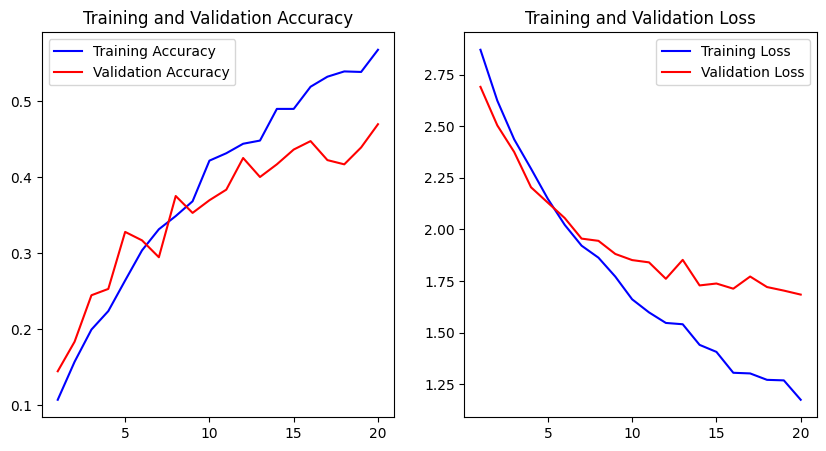

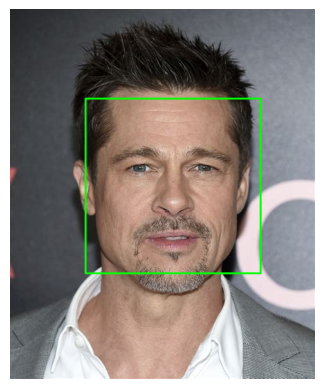

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
from google.colab import drive

def load_data_from_folder(folder_path, image_size):
    """Loads images and labels from a folder containing subdirectories for each class."""
    data = []
    labels = []
    classes = []

    for idx, class_dir in enumerate(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_dir)
        if os.path.isdir(class_path):
            classes.append(class_dir)
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    data.append(img_array)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

    data = np.array(data, dtype='float32') / 255.0
    labels = np.array(labels)
    return data, labels, classes


def extract_features(model, data):
    """Extracts features using a pre-trained model."""
    features = model.predict(data, batch_size=32, verbose=1)
    return features

def create_generators(data, labels, batch_size):
    """Creates shuffled training and validation datasets."""
    data, labels = shuffle(data, labels, random_state=42)
    split_idx = int(0.8 * len(data))

    train_data, val_data = data[:split_idx], data[split_idx:]
    train_labels, val_labels = labels[:split_idx], labels[split_idx:]

    train_generator = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(batch_size).shuffle(len(train_data))
    val_generator = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(batch_size)

    return train_generator, val_generator


def build_cnn(input_shape, num_classes):
    """Builds a CNN model."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def plot_training_results(history):
    """Plots training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


def detect_and_draw_face(image_path):
    """Detects face in the image and draws a bounding box around it."""

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


    img = cv2.imread(image_path)


    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))


    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)


    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()


def main():
    dataset_folder = "/content/drive/MyDrive/Celebrity Faces Dataset"


    image_size = (128, 128)
    batch_size = 32

    data, labels, classes = load_data_from_folder(dataset_folder, image_size)

    feature_extractor = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    feature_extractor.trainable = False
    features = extract_features(feature_extractor, data)
    features = features.reshape(features.shape[0], -1)


    train_generator, val_generator = create_generators(features, labels, batch_size)

    input_shape = (features.shape[1],)
    num_classes = len(classes)


    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    epochs = 20
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs
    )


    print("Class Indices:", {i: c for i, c in enumerate(classes)})

    plot_training_results(history)

    sample_image_path = "/content/drive/MyDrive/Celebrity Faces Dataset/Brad Pitt/001_c04300ef.jpg"
    detect_and_draw_face(sample_image_path)

if __name__ == '__main__':
    main()